In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd

File = '/content/drive/MyDrive/Algoritmos/Datathon/Datos/IdentificacionSesgo - DataSet29.06.csv'
df = pd.read_csv(File, header = 0)

In [4]:
df['GravedadMode'] = df['Gravedad'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]


In [5]:
df = df[['Item (Texto)', 'GravedadMode']]


In [6]:
x = df['Item (Texto)'].values
y = df['GravedadMode'].values

In [7]:
from tensorflow import keras
%tensorflow_version 2.x

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [9]:
t = Tokenizer()
t.fit_on_texts(x)

In [10]:
vocab_size = len(t.word_index) + 1
print(vocab_size)

3209


In [11]:
sequences = t.texts_to_sequences(x)

In [13]:
import numpy as np

np.shape(sequences)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(146,)

In [14]:
def max_news():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [15]:
news_num = max_news()
news_num

76

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_x = pad_sequences(sequences, padding='pre', maxlen=news_num)

In [17]:
labels = to_categorical(np.asarray(y))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(padded_x, labels, test_size = 0.2, random_state = 0)

In [19]:
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (116, 76)
y_train size: (116, 4)
X_test size: (30, 76)
y_test size: (30, 4)


In [20]:
import os

In [21]:
cd /content/drive/MyDrive/Algoritmos/Datathon/Embeddings

/content/drive/MyDrive/Algoritmos/Datathon/Embeddings


In [23]:
ls

embeddings-l-model.vec  fasttext-sbwc.300k.vec


In [25]:
from gensim.models import KeyedVectors
import logging

logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

vectors = KeyedVectors.load_word2vec_format('embeddings-l-model.vec', binary = False)

2021-07-02 17:09:58,944 : loading projection weights from embeddings-l-model.vec
2021-07-02 17:15:21,253 : loaded (1313423, 300) matrix from embeddings-l-model.vec


In [24]:
import numpy as np

embeddings_index = dict()
f = open('embeddings-l-model.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1313424 word vectors.


In [26]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

In [27]:
# Definición del tamaño de la matriz embedding: Número de palabas únicas x dimensión del embedding (100)
embedding_matrix = np.zeros((vocab_size, 300))

# relleno de la matriz
for word, i in t.word_index.items():  # diccionario
    embedding_vector = embeddings_index.get(word) # obtención de los vectores embedded de la palabra en GloVe.
    if embedding_vector is not None:
        # adición en la matriz
        embedding_matrix[i] = embedding_vector # cada fila de la matriz.

In [35]:
keras.backend.clear_session()

# Creación de la capa embedding esando la matriz embedding predefinida.
from tensorflow.keras.layers import Embedding

# la entrada será vocab_size, y la salida 300
# para cargar los pesos de la matriz embedding hacemos trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix],
                           input_length = news_num, trainable=False)

In [36]:
lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(456, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(4, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod1.summary()

2021-07-02 17:18:36,147 : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 76, 300)           962700    
_________________________________________________________________
lstm (LSTM)                  (None, 456)               1380768   
_________________________________________________________________
dense (Dense)                (None, 4)                 1828      
Total params: 2,345,296
Trainable params: 1,382,596
Non-trainable params: 962,700
_________________________________________________________________


In [37]:
es=EarlyStopping(monitor='val_loss',patience=10)

hist_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, callbacks=[es],batch_size=456)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.3948 - acc: 0.1413 - val_loss: 1.3838 - val_acc: 0.2083
Epoch 2/100
1/1 [==============================] - 0s 359ms/step - loss: 1.3220 - acc: 0.3370 - val_loss: 1.3709 - val_acc: 0.3333
Epoch 3/100
1/1 [==============================] - 0s 329ms/step - loss: 1.2540 - acc: 0.5543 - val_loss: 1.3549 - val_acc: 0.3750
Epoch 4/100
1/1 [==============================] - 0s 342ms/step - loss: 1.1772 - acc: 0.6739 - val_loss: 1.3401 - val_acc: 0.3333
Epoch 5/100
1/1 [==============================] - 0s 339ms/step - loss: 1.0919 - acc: 0.6413 - val_loss: 1.3131 - val_acc: 0.4583
Epoch 6/100
1/1 [==============================] - 0s 381ms/step - loss: 0.9863 - acc: 0.7500 - val_loss: 1.3552 - val_acc: 0.4167
Epoch 7/100
1/1 [==============================] - 0s 351ms/step - loss: 0.9151 - acc: 0.6739 - val_loss: 2.1940 - val_acc: 0.2917
Epoch 8/100
1/1 [==============================] - 0s 328ms/step - loss: 1.7362 - acc:

In [38]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.6379
Testing Accuracy:  0.3667


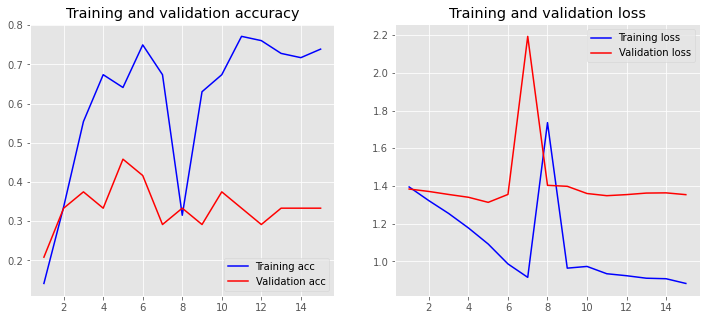

In [39]:
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_1)